### This notebook is to create Figure 2 in Liu & Grise 2025.

#### import libraries

In [1]:
import numpy as np
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import xarray as xr
import pickle
import os
import time
from utils import *

#### load monthly SAM index for different models calculated in calculate_SAM_models.ipynb

In [2]:
save_directory = '../data'
with open(os.path.join(save_directory, 'sam_models_monthly_2000_2014.pkl'), 'rb') as f:
    sam_models_monthly = pickle.load(f)

#### functions to calculate regression coefficient and p-value

In [3]:
def calc_slope_and_pval(x, y):
    # Remove NaN values from x and y
    mask = ~np.isnan(x) & ~np.isnan(y)  # Only keep pairs where neither is NaN
    if np.sum(mask) < 2:  # If not enough valid points, return NaN
        return np.nan, np.nan
    # Perform linear regression using only valid points
    slope, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])
    return slope, p_value

In [4]:
def calculate_regression_with_pvalues(file, jet_latitudes_noseason, lat_range, file_type, MERRA2=False, cloudsat=False, cloudsat_CRH=False):
    # Load and select time and latitude range based on file type
    if cloudsat:
        dataset = xr.open_dataset(file).sel(time=slice('2007', '2019')).sel(lat=slice(*lat_range))
        full_time_range = pd.date_range(start=dataset.time.min().values, end=dataset.time.max().values, freq='MS')
        dataset = dataset.reindex(time=full_time_range)
    elif cloudsat_CRH:
        dataset = xr.open_dataset(file).sel(time=slice('2007', '2018')).sel(lat=slice(*lat_range))
        full_time_range = pd.date_range(start=dataset.time.min().values, end=dataset.time.max().values, freq='5D')
        dataset = dataset.reindex(time=full_time_range)
    else:
        dataset = xr.open_dataset(file).sel(time=slice('2000', '2014')).sel(lat=slice(*lat_range))
    
    common_lat_grid = np.arange(-90, 1, 1)
    
    dayofyear_mean = dataset.groupby('time.dayofyear').mean(dim='time')
    anomaly = dataset.groupby('time.dayofyear') - dayofyear_mean
    
    if file_type == 'cloud_fraction':
        if MERRA2:
            data_var = anomaly['CLOUD']
        elif cloudsat:
            data_var = anomaly['cloud_fraction_on_levels']
        else:
            data_var = anomaly['cl']
    elif file_type == 'cloud_radiative_heating':
        if MERRA2:
            #data_var = anomaly['DTDTLWR'] + anomaly['DTDTSWR'] - anomaly['DTDTLWRCLR'] - anomaly['DTDTSWRCLR']
            data_var = anomaly['DTDTLWR'] - anomaly['DTDTLWRCLR']
        elif cloudsat_CRH:
            data_var = dataset['CRH_LWcloud']
        else:
            data_var = anomaly['temp_tendency_K_day']
    
    data_var_interp = data_var.interp(lat=common_lat_grid)
    
    regression_result = xr.apply_ufunc(
        calc_slope_and_pval,
        jet_latitudes_noseason,
        np.squeeze(data_var_interp),
        input_core_dims=[['time'], ['time']],
        vectorize=True,
        dask='parallelized',
        output_core_dims=[[], []],
        output_dtypes=[float, float]
    )
    
    regression_coeff, p_values = regression_result
    print(regression_coeff.shape)
    
    model_name = file.split('/')[-1].split('_')[2]
    if MERRA2:
        regression_coeff_da = xr.DataArray(regression_coeff * (86400 if file_type == 'cloud_radiative_heating' else 100),
                                           dims=['lev', 'lat'], coords={'lat': common_lat_grid, 'lev': dataset['lev']})
        p_values_da = xr.DataArray(p_values, dims=['lev', 'lat'], coords={'lat': common_lat_grid, 'lev': dataset['lev']})
    elif cloudsat:
        regression_coeff_da = xr.DataArray(regression_coeff.mean(dim = 'doop'), dims=['lat', 'lev'], coords={'lat': common_lat_grid, 'lev': dataset['lev'] / 100})
        p_values_da = xr.DataArray(p_values.mean(dim = 'doop'), dims=['lat', 'lev'], coords={'lat': common_lat_grid, 'lev': dataset['lev'] / 100})
    elif cloudsat_CRH:
        regression_coeff_da = xr.DataArray(regression_coeff, dims=['lat', 'lev'], coords={'lat': common_lat_grid, 'lev': dataset['lev'] / 100})
        p_values_da = xr.DataArray(p_values, dims=['lat', 'lev'], coords={'lat': common_lat_grid, 'lev': dataset['lev'] / 100})
    elif model_name in ['CAS-ESM2-0', 'CIESM']:
        regression_coeff_da = xr.DataArray(regression_coeff * 100, dims=['lev', 'lat'],
                                           coords={'lat': common_lat_grid, 'lev': dataset['lev'] / 100})
        p_values_da = xr.DataArray(p_values, dims=['lev', 'lat'], coords={'lat': common_lat_grid, 'lev': dataset['lev']/100})
    else:
        if file_type == 'cloud_fraction':
            regression_coeff_da = xr.DataArray(regression_coeff, dims=['lev', 'lat'], coords={'lat': common_lat_grid, 'lev': dataset['lev'] / 100})
            p_values_da = xr.DataArray(p_values, dims=['lev', 'lat'], coords={'lat': common_lat_grid, 'lev': dataset['lev'] / 100})
        else:
            regression_coeff_da = xr.DataArray(regression_coeff, dims=['lev', 'lat'],
                                           coords={'lat': common_lat_grid, 'lev': dataset['lev']})
            p_values_da = xr.DataArray(p_values, dims=['lev', 'lat'], coords={'lat': common_lat_grid, 'lev': dataset['lev']})
    
    return regression_coeff_da, p_values_da

In [ ]:
directory = '/OWC/huiyu/CMIP6/vertical_CRH/interpolated'
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.nc')]
files

['/OWC/huiyu/CMIP6/vertical_CRH/interpolated/MRI-ESM2-0_CRH_interpolated_zonalmean.nc',
 '/OWC/huiyu/CMIP6/vertical_CRH/interpolated/MPI-ESM1-2-LR_CRH_interpolated_zonalmean.nc',
 '/OWC/huiyu/CMIP6/vertical_CRH/interpolated/MPI-ESM1-2-HR_CRH_interpolated_zonalmean.nc',
 '/OWC/huiyu/CMIP6/vertical_CRH/interpolated/MPI-ESM-1-2-HAM_CRH_interpolated_zonalmean.nc',
 '/OWC/huiyu/CMIP6/vertical_CRH/interpolated/MIROC6_CRH_interpolated_zonalmean.nc',
 '/OWC/huiyu/CMIP6/vertical_CRH/interpolated/INM-CM4-8_CRH_interpolated_zonalmean.nc',
 '/OWC/huiyu/CMIP6/vertical_CRH/interpolated/INM-CM5-0_CRH_interpolated_zonalmean.nc',
 '/OWC/huiyu/CMIP6/vertical_CRH/interpolated/BCC-CSM2-MR_CRH_interpolated_zonalmean.nc']

### calculating regression patterns for CL and CRH from cloudsat and MERRA2 data

In [5]:
directory = '/bjerknes_raid5/CMIP6_xl7pd/amip_monthly/cl_combined/zonal_mean_interped/'
file_names = os.listdir(directory)
files = []
for file in file_names:
     files.append(directory+file)
print(len(files))

27


In [14]:
xr.open_dataset('/bjerknes_raid5/cloudsat/CL_CloudSat_monthly_combined_interped.nc')

<xarray.Dataset> Size: 38MB
Dimensions:                                 (time: 141, doop: 2, lat: 72,
                                             lev: 40, type: 8, localhour: 4,
                                             bound: 2)
Coordinates:
  * lat                                     (lat) float64 576B -88.75 ... 88.75
  * doop                                    (doop) |S16 32B b'DO-OP observabl...
  * type                                    (type) |S12 96B b'any' ... b'uniq...
  * localhour                               (localhour) |S5 20B b'01:00' ... ...
  * time                                    (time) datetime64[ns] 1kB 2006-06...
  * lev                                     (lev) float64 320B 1e+05 ... 2.5e+03
Dimensions without coordinates: bound
Data variables: (12/14)
    cloud_counts_on_levels                  (time, doop, lat, lev) float64 6MB ...
    total_counts_on_levels                  (time, doop, lat, lev) float64 6MB ...
    cloud_fraction_on_levels                (time, doop, lat, lev) float64 6MB ...
    cloud_counts_in_column                  (time, type, doop, lat) float64 1MB ...
    total_counts_in_column                  (time, type, doop, lat) float64 1MB ...
    cloud_cover_in_column                   (time, type, doop, lat) float64 1MB ...
    ...                                      ...
    radar_surface_clutter_counts_on_levels  (time, doop, lat, lev) float64 6MB ...
    n_overpasses                            (time, doop, lat) float64 162kB ...
    n_days                                  (time, doop, lat) float64 162kB ...
    localhour_counts                        (time, localhour, doop, lat) float64 650kB ...
    localhour_bounds                        (time, localhour, bound) |S5 6kB ...
    height_bounds                           (time, lev, bound) float64 90kB ...

In [6]:
file_type = 'cloud_fraction'
sam_merra2 = calculate_sam_models('/bjerknes_raid5/MERRA2_xl7pd/monthly/u_5levels/MERRA2_u_5levels.200001-202312.nc', MERRA2=True)
file = '/bjerknes_raid5/MERRA2_xl7pd/monthly/CRH/2000-2023/zonal_mean/MERRA2_CRH_CF.tavgM_3d_rad_Np.200001-202312_zonal_mean.nc4'
sam_merra2_df = sam_merra2.sort_index().loc['2000':'2014']
sam_anomaly_merra2 = (sam_merra2_df - sam_merra2_df.mean()) / sam_merra2_df.std()
lat_range = (-90, 0)
regression_coeff_merra2_cl, p_values_merra2_cl = calculate_regression_with_pvalues(file, sam_anomaly_merra2.values, lat_range, file_type, MERRA2=True)

file = '/bjerknes_raid5/cloudsat/CL_CloudSat_monthly_combined_interped.nc'
#sam_era5_df = sam_era5.resample('ME').mean().sort_index().loc['2007':'2014']
#sam_anomaly_era5 = (sam_era5_df - sam_era5_df.mean()) / sam_era5_df.std()
#sam_era5_df = calculate_sam_models('../code/uwind_monthly_ERA5.nc', ERA5=True)
#sam_era5_df = sam_era5_df.sort_index().loc['2007':'2018']
#sam_anomaly_era5 = (sam_era5_df - sam_era5_df.mean()) / sam_era5_df.std()
sam_merra2_df = sam_merra2.sort_index().loc['2007':'2019']
sam_anomaly_merra2 = (sam_merra2_df - sam_merra2_df.mean()) / sam_merra2_df.std()
lat_range = (-90, 0)
#regression_coeff_cloudsat_cl, p_values_cloudsat_cl = calculate_regression_with_pvalues(file, sam_anomaly_era5.values, lat_range, file_type, cloudsat=True)
regression_coeff_cloudsat_cl, p_values_cloudsat_cl = calculate_regression_with_pvalues(file, sam_anomaly_merra2.values, lat_range, file_type, cloudsat=True)

read in done
(288, 505)
(40, 91)
(2, 91, 40)


In [7]:
file_type = 'cloud_radiative_heating'
sam_merra2 = calculate_sam_models('/bjerknes_raid5/MERRA2_xl7pd/monthly/u_5levels/MERRA2_u_5levels.200001-202312.nc', MERRA2=True)
file = '/bjerknes_raid5/MERRA2_xl7pd/monthly/CRH/2000-2023/zonal_mean/MERRA2_CRH_CF.tavgM_3d_rad_Np.200001-202312_zonal_mean.nc4'
sam_merra2_df = sam_merra2.sort_index().loc['2000':'2014']
sam_anomaly_merra2 = (sam_merra2_df - sam_merra2_df.mean()) / sam_merra2_df.std()
lat_range = (-90, 0)
regression_coeff_merra2_crh, p_values_merra2_crh = calculate_regression_with_pvalues(file, sam_anomaly_merra2.values, lat_range, file_type, MERRA2=True)

file = '/bjerknes_raid5/cloudsat/CRH_LW_CloudSat_combined_interped.nc'
sam_era5_df = calculate_sam_models('../code/uwind_daily_ERA5.nc', ERA5=True)
sam_era5_df = sam_era5_df.sort_index().loc['2007':'2010'].resample('5D').mean()
sam_anomaly_era5 = (sam_era5_df - sam_era5_df.mean()) / sam_era5_df.std()
sam_merra2 = calculate_sam_models('/bjerknes_raid5/MERRA2_xl7pd/MERRA2_daily_u_5levels.200001-202412.nc', MERRA2=True)
sam_merra2_df = sam_merra2.sort_index().loc['2007':'2010'].resample('5D').mean()
sam_anomaly_merra2 = (sam_merra2_df - sam_merra2_df.mean()) / sam_merra2_df.std()
lat_range = (-90, 0)
#regression_coeff_cloudsat_crh, p_values_cloudsat_crh = calculate_regression_with_pvalues(file, sam_anomaly_era5.values, lat_range, file_type, cloudsat_CRH=True)
regression_coeff_cloudsat_crh, p_values_cloudsat_crh = calculate_regression_with_pvalues(file, sam_anomaly_merra2.values, lat_range, file_type, cloudsat_CRH=True)

read in done
(288, 505)
(40, 91)
read in done
(15706, 330)
read in done
(5479, 505)
(91, 40)


### read regression maps for models

In [8]:
save_directory = '../data'
with open(os.path.join(save_directory, 'regression_maps_cloud_fraction.pkl'), 'rb') as f:
    regression_maps_models_cl = pickle.load(f)

with open(os.path.join(save_directory, 'regression_maps_cloud_fraction_p_values.pkl'), 'rb') as f:
    regression_coeffs_cl_sam_models_p_values = pickle.load(f)

In [9]:
save_directory = '../data'
with open(os.path.join(save_directory, 'regression_maps_crh.pkl'), 'rb') as f:
    regression_maps_models_crh = pickle.load(f)

with open(os.path.join(save_directory, 'regression_maps_crh_p_values.pkl'), 'rb') as f:
    regression_coeffs_crh_sam_models_p_values = pickle.load(f)

In [10]:
# models that have jet-acre values in Fig. 1
models = ['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'CAS-ESM2-0',
 'CIESM',
 'CMCC-CM2-HR4',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'EC-Earth3-CC',
 'FGOALS-f3-L',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'INM-CM4-8',
 'INM-CM5-0',
 'KACE-1-0-G',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorCPM1',
 'SAM0-UNICON',
 'UKESM1-0-LL']

In [11]:
regression_coeffs_list_cl = []
for model in models:
    if model in regression_maps_models_cl.keys():
        regression_coeffs_list_cl.append(regression_maps_models_cl[model])

# Calculate the model-mean and inter-model spread (standard deviation)
regression_coeffs_stack_cl = np.stack([coeff.values for coeff in regression_coeffs_list_cl])
model_mean_coeff = np.mean(regression_coeffs_stack_cl, axis=0)
model_spread_coeff = np.std(regression_coeffs_stack_cl, axis=0)

# Convert the mean and spread back to xarray DataArray with appropriate coordinates
mean_da_cl = xr.DataArray(model_mean_coeff, dims=regression_coeffs_list_cl[0].dims, coords=regression_coeffs_list_cl[0].coords)
spread_da_cl = xr.DataArray(model_spread_coeff, dims=regression_coeffs_list_cl[0].dims, coords=regression_coeffs_list_cl[0].coords)

regression_coeffs_list_crh = []
for model in regression_maps_models_crh.keys():
    if model != 'BCC-CSM2-MR':
        regression_coeffs_list_crh.append(regression_maps_models_crh[model])

# Calculate the model-mean and inter-model spread (standard deviation)
regression_coeffs_stack_crh = np.stack([coeff.values for coeff in regression_coeffs_list_crh])
model_mean_coeff = np.mean(regression_coeffs_stack_crh, axis=0)
model_spread_coeff = np.std(regression_coeffs_stack_crh, axis=0)

# Convert the mean and spread back to xarray DataArray with appropriate coordinates
mean_da_crh = xr.DataArray(model_mean_coeff, dims=regression_coeffs_list_crh[0].dims, coords=regression_coeffs_list_crh[0].coords)
spread_da_crh = xr.DataArray(model_spread_coeff, dims=regression_coeffs_list_crh[0].dims, coords=regression_coeffs_list_crh[0].coords)

<>:70: SyntaxWarning: invalid escape sequence '\s'
<>:143: SyntaxWarning: invalid escape sequence '\s'
<>:70: SyntaxWarning: invalid escape sequence '\s'
<>:143: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_61188/1421469898.py:70: SyntaxWarning: invalid escape sequence '\s'
  cbar1.set_label('Regression Coefficient (% $\sigma_s^{-1}$)', fontsize=25)
/tmp/ipykernel_61188/1421469898.py:143: SyntaxWarning: invalid escape sequence '\s'
  cbar3.set_label('Regression Coefficient (K $day^{-1}$ $\sigma_s^{-1}$)', fontsize=25)
/tmp/ipykernel_61188/1421469898.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.99])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


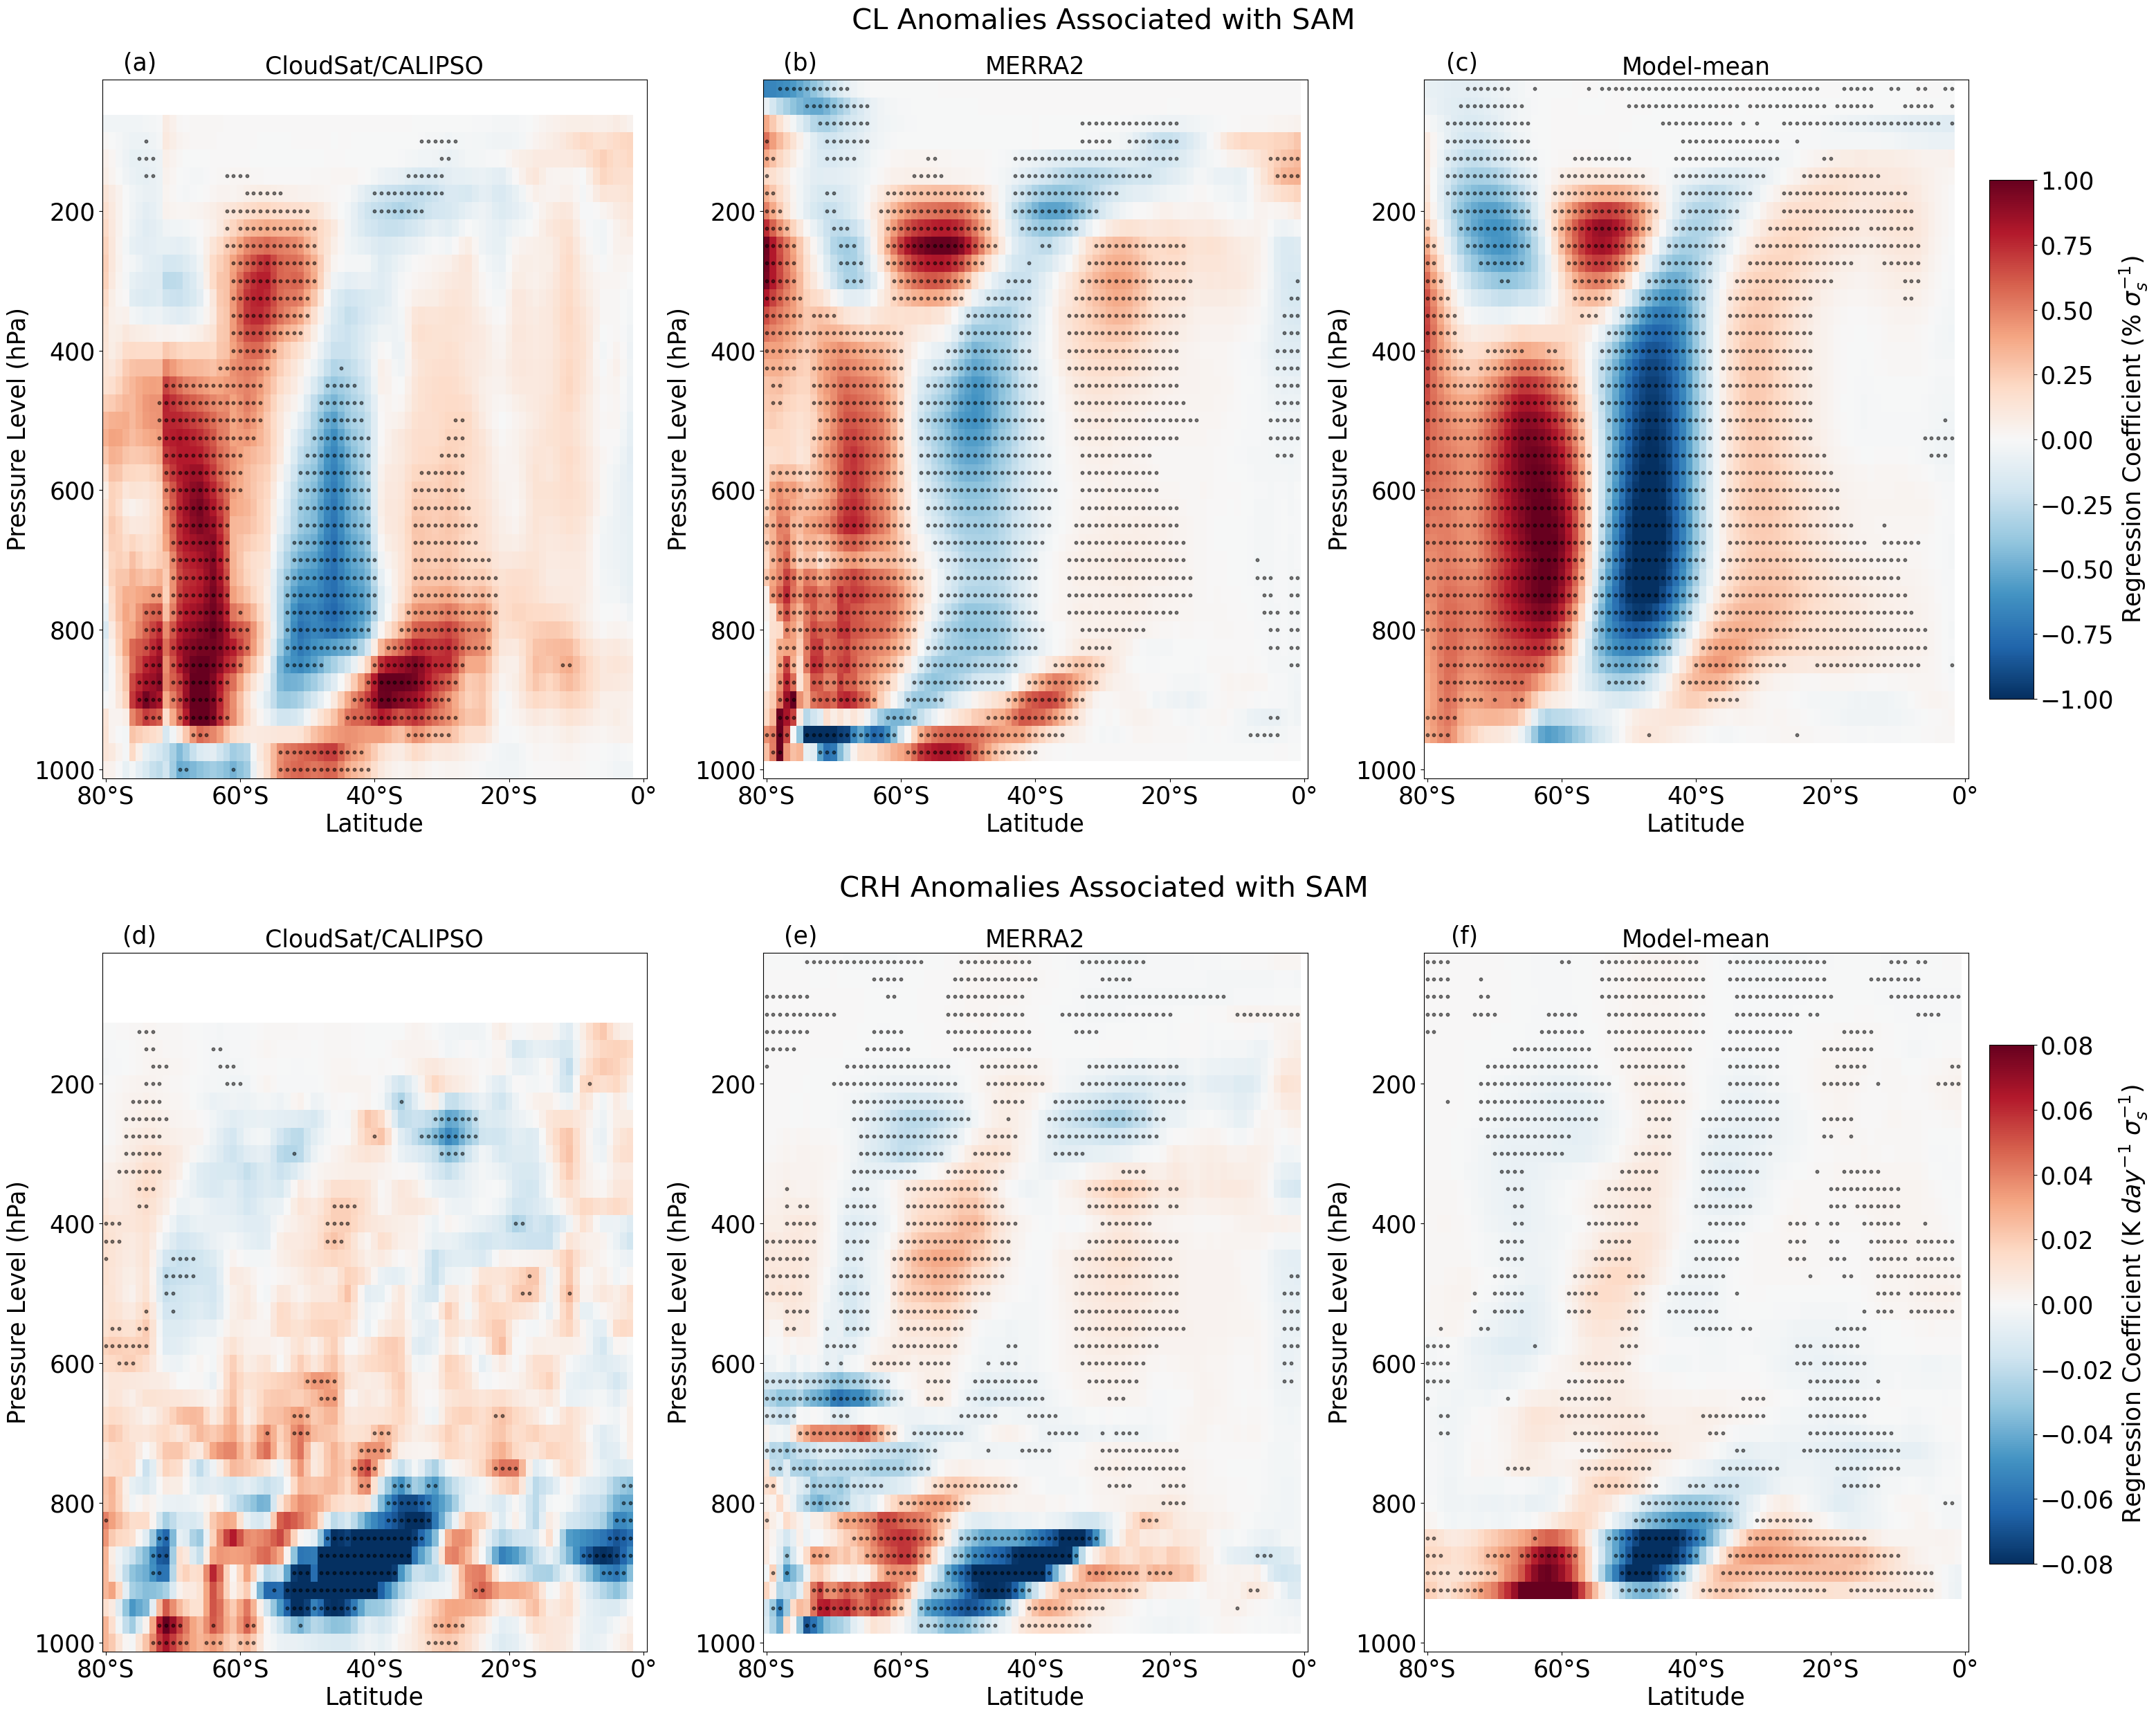

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(32, 25))

num_models = len(regression_coeffs_list_cl)
positive_agreement = (regression_coeffs_stack_cl > 0)

positive_agreement_sum = np.sum(positive_agreement, axis=0)

agreement_threshold = 0.8 * num_models
agreement_mask_cl = (positive_agreement_sum >= agreement_threshold) | (positive_agreement_sum <= (num_models - agreement_threshold))

nan_mask_cl = ~np.isnan(mean_da_cl.values)  
final_mask_cl = agreement_mask_cl & nan_mask_cl

vmin_mean = -1
vmax_mean = 1
vmin_spread = 0
vmax_spread = 1

# Plot the regression coefficients for MERRA2
ax = axes[0, 0]
regression_coeff_cloudsat_cl.sel(lat=slice(-80,0)).plot(ax=ax, x='lat', y='lev', cmap='RdBu_r', vmin=vmin_mean, vmax=vmax_mean, yincrease=False, add_colorbar=False)
sig_mask = p_values_cloudsat_cl < 0.05
latitudes, levels = np.meshgrid(regression_coeff_cloudsat_cl['lat'].values, regression_coeff_cloudsat_cl['lev'].values)
ax.scatter(latitudes.T[sig_mask], levels.T[sig_mask], color='black', s=10, alpha=0.5)
ax.text(0.1, 1.04, '(a)', transform=ax.transAxes, fontsize=25,  va='top', ha='right')
ax.set_title('CloudSat/CALIPSO', fontsize=25)
ax.set_xlabel('Latitude', fontsize=25)
ax.set_ylabel('Pressure Level (hPa)', fontsize=25)
latitude_ticks = [-80, -60, -40, -20, 0]
latitude_labels = ['80°S', '60°S', '40°S', '20°S', '0°']
ax.set_xticks(latitude_ticks)
ax.set_xticklabels(latitude_labels, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)

ax = axes[0, 1]
regression_coeff_merra2_cl.where(regression_coeff_merra2_cl['lev'] < 1000, np.nan).sel(lat=slice(-80,0)).plot(ax=ax, x='lat', y='lev', cmap='RdBu_r', vmin=vmin_mean, vmax=vmax_mean, yincrease=False, add_colorbar=False)

sig_mask = p_values_merra2_cl.where(regression_coeff_merra2_cl['lev'] < 1000, np.nan) < 0.05
latitudes, levels = np.meshgrid(regression_coeff_merra2_cl['lat'].values, regression_coeff_merra2_cl['lev'].values)
ax.scatter(latitudes[sig_mask], levels[sig_mask], color='black', s=10, alpha=0.5)
ax.text(0.1, 1.04, '(b)', transform=ax.transAxes, fontsize=25,  va='top', ha='right')
ax.set_title('MERRA2', fontsize=25)
ax.set_xlabel('Latitude', fontsize=25)
ax.set_ylabel('Pressure Level (hPa)', fontsize=25)
latitude_ticks = [-80, -60, -40, -20, 0]
latitude_labels = ['80°S', '60°S', '40°S', '20°S', '0°']
ax.set_xticks(latitude_ticks)
ax.set_xticklabels(latitude_labels, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)

# Plot the model-mean
ax = axes[0, 2]
mean_da_cl.sel(lat=slice(-80,0)).plot(ax=ax, x='lat', y='lev', cmap='RdBu_r', vmin=vmin_mean, vmax=vmax_mean, yincrease=False, add_colorbar=False)
ax.set_title('Model-mean', fontsize=25)
ax.text(0.1, 1.04, '(c)', transform=ax.transAxes, fontsize=25,  va='top', ha='right')
ax.set_xlabel('Latitude', fontsize=25)
ax.set_ylabel('Pressure Level (hPa)', fontsize=25)
latitude_ticks = [-80, -60, -40, -20, 0]
latitude_labels = ['80°S', '60°S', '40°S', '20°S', '0°']
ax.set_xticks(latitude_ticks)
ax.set_xticklabels(latitude_labels, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)

latitudes, levels = np.meshgrid(mean_da_cl['lat'].values, mean_da_cl['lev'].values)
ax.scatter(latitudes[final_mask_cl], levels[final_mask_cl], color='black', s=10, alpha=0.5)

# Colorbar for top panels
cbar_ax1 = fig.add_axes([0.9, 0.59, 0.02, 0.3])  # Adjusted position and size of colorbar
cbar1 = plt.colorbar(axes[0, 0].collections[0], cax=cbar_ax1, orientation='vertical')
cbar1.set_label('Regression Coefficient (% $\sigma_s^{-1}$)', fontsize=25)
cbar1.ax.tick_params(labelsize=25)


num_models = len(regression_coeffs_list_crh)
positive_agreement = (regression_coeffs_stack_crh > 0)

positive_agreement_sum = np.sum(positive_agreement, axis=0)

agreement_threshold = 0.8 * num_models
agreement_mask_crh = (positive_agreement_sum >= agreement_threshold) | (positive_agreement_sum <= (num_models - agreement_threshold))

nan_mask_crh = ~np.isnan(mean_da_crh.values)  
final_mask_crh = agreement_mask_crh & nan_mask_crh


vmin_mean = -0.08
vmax_mean = 0.08
vmin_spread = 0
vmax_spread = 0.08

# Plot the regression coefficients for CloudSat
ax = axes[1, 0]
regression_coeff_cloudsat_crh.sel(lat=slice(-80,0)).plot(ax=ax, x='lat', y='lev', cmap='RdBu_r', vmin=vmin_mean, vmax=vmax_mean, yincrease=False, add_colorbar=False)
sig_mask = p_values_cloudsat_crh < 0.05
latitudes, levels = np.meshgrid(regression_coeff_cloudsat_crh['lat'].values, regression_coeff_cloudsat_crh['lev'].values)
ax.scatter(latitudes[sig_mask.T], levels[sig_mask.T], color='black', s=10, alpha=0.5)
ax.set_title('CloudSat/CALIPSO', fontsize=25)
ax.set_xlabel('Latitude', fontsize=25)
ax.set_ylabel('Pressure Level (hPa)', fontsize=25)
latitude_ticks = [-80, -60, -40, -20, 0]
latitude_labels = ['80°S', '60°S', '40°S', '20°S', '0°']
ax.set_xticks(latitude_ticks)
ax.set_xticklabels(latitude_labels, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.text(0.1, 1.04, '(d)', transform=ax.transAxes, fontsize=25,  va='top', ha='right')

# Plot the regression coefficients for MERRA2
ax = axes[1, 1]
regression_coeff_merra2_crh.where(regression_coeff_merra2_crh['lev'] < 1000, np.nan).sel(lat=slice(-80,0)).plot(ax=ax, x='lat', y='lev', cmap='RdBu_r', vmin=vmin_mean, vmax=vmax_mean, yincrease=False, add_colorbar=False)

sig_mask = p_values_merra2_crh.where(regression_coeff_merra2_crh['lev'] < 1000, np.nan) < 0.05
latitudes, levels = np.meshgrid(regression_coeff_merra2_crh['lat'].values, regression_coeff_merra2_crh['lev'].values)
ax.scatter(latitudes[sig_mask], levels[sig_mask], color='black', s=10, alpha=0.5)

ax.set_title('MERRA2', fontsize=25)
ax.set_xlabel('Latitude', fontsize=25)
ax.set_ylabel('Pressure Level (hPa)', fontsize=25)
latitude_ticks = [-80, -60, -40, -20, 0]
latitude_labels = ['80°S', '60°S', '40°S', '20°S', '0°']
ax.set_xticks(latitude_ticks)
ax.set_xticklabels(latitude_labels, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.text(0.1, 1.04, '(e)', transform=ax.transAxes, fontsize=25,  va='top', ha='right')

# Plot the model-mean
ax = axes[1, 2]
mean_da_crh.sel(lat=slice(-80,0)).plot(ax=ax, x='lat', y='lev', cmap='RdBu_r', vmin=vmin_mean, vmax=vmax_mean, yincrease=False, add_colorbar=False)
ax.set_title('Model-mean', fontsize=25)
ax.set_xlabel('Latitude', fontsize=25)
ax.set_ylabel('Pressure Level (hPa)', fontsize=25)
latitude_ticks = [-80, -60, -40, -20, 0]
latitude_labels = ['80°S', '60°S', '40°S', '20°S', '0°']
ax.set_xticks(latitude_ticks)
ax.set_xticklabels(latitude_labels, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.text(0.1, 1.04, '(f)', transform=ax.transAxes, fontsize=25,  va='top', ha='right')
latitudes, levels = np.meshgrid(mean_da_crh['lat'].values, mean_da_crh['lev'].values)
ax.scatter(latitudes[final_mask_crh], levels[final_mask_crh], color='black', s=10, alpha=0.5)

# Colorbar for MERRA2 and (model-mean)
cbar_ax3 = fig.add_axes([0.9, 0.09, 0.02, 0.3])  # Adjusted position and size of colorbar
cbar3 = plt.colorbar(axes[1, 0].collections[0], cax=cbar_ax3, orientation='vertical')
cbar3.set_label('Regression Coefficient (K $day^{-1}$ $\sigma_s^{-1}$)', fontsize=25)
cbar3.ax.tick_params(labelsize=25)

# Add a title for the whole figure
fig.suptitle('CL Anomalies Associated with SAM', fontsize=30, x=0.5, y=0.99)
fig.text(s='CRH Anomalies Associated with SAM', x=0.5, y=0.48, fontsize=30, ha='center', va='center')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 0.99])
plt.subplots_adjust(hspace=0.25)  # Adjusted spacing for subplots
plt.savefig('../figures/fig_2_vertical_acre_cl_sam_pressure_level.eps', format='eps', dpi=300)

plt.show()